In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
import cv2

In [2]:
# defining global variable path
image_path = "./data"
output_path = "./processed_data"

def loadImages(path):
    # Put files into lists and return them as one list of size 4
    file_path = os.path.join(image_path, path)
    image_files = sorted([os.path.join(file_path, file)
         for file in os.listdir(file_path) if      file.endswith('.png')])
 
    return image_files

In [3]:
from numpy import *

def rof_denoise(im,U_init,tolerance=0.1,tau=0.125,tv_weight=100):
  """ An implementation of the Rudin-Osher-Fatemi (ROF) denoising model
    using the numerical procedure presented in eq (11) A. Chambolle (2005).

    Input: noisy input image (grayscale), initial guess for U, weight of
    the TV-regularizing term, steplength, tolerance for stop criterion.

    Output: denoised and detextured image, texture residual. """

  m,n = im.shape # size of noisy image

  # initialize
  U = U_init
  Px = im # x-component to the dual field
  Py = im # y-component of the dual field
  error = 1

  while (error > tolerance):
    Uold = U

    # gradient of primal variable
    GradUx = np.roll(U,-1,axis=1)-U # x-component of U's gradient
    GradUy = np.roll(U,-1,axis=0)-U # y-component of U's gradient

    # update the dual varible
    PxNew = Px + (tau/tv_weight)*GradUx
    PyNew = Py + (tau/tv_weight)*GradUy
    NormNew = maximum(1,sqrt(PxNew**2+PyNew**2))

    Px = PxNew/NormNew # update of x-component (dual)
    Py = PyNew/NormNew # update of y-component (dual)

    # update the primal variable
    RxPx = np.roll(Px,1,axis=1) # right x-translation of x-component
    RyPy = np.roll(Py,1,axis=0) # right y-translation of y-component

    DivP = (Px-RxPx)+(Py-RyPy) # divergence of the dual field.
    U = im + tv_weight*DivP # update of the primal variable

    # update of error
    error = linalg.norm(U-Uold)/sqrt(n*m);

  return U,im-U # denoised image and texture residual

In [4]:

# Display one image
def display_one(a, title1 = "Original"):
    plt.imshow(a, cmap=plt.get_cmap('gray')), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.show()
# Display two images
def display(a, b, title1 = "Original", title2 = "Edited"):
    plt.subplot(121), plt.imshow(a, cmap=plt.get_cmap('gray')), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(b, cmap=plt.get_cmap('gray')), plt.title(title2)
    plt.xticks([]), plt.yticks([])
    plt.show()
    

In [31]:

    
# Preprocessing
def processing(path):
    
    # loading image
    data = loadImages(path)
    # Getting 3 images to work with 
    img = [cv2.imread(i, cv2.IMREAD_UNCHANGED) for i in data]

    display_one(img[0])
    print('Original size',img[0].shape)
    # --------------------------------
    # setting dim of the resize
    height = 220
    width = 220
    dim = (width, height)
    res_img = []
    for i in range(len(img)):
        res = cv2.resize(img[i], dim, interpolation=cv2.INTER_LINEAR)
#         res = cv2.resize(img[i], dim)
        res_img.append(res)

    # Checcking the size
    print("RESIZED", res_img[0].shape)
    
#     # Visualizing one of the images in the array
#     original = res_img[0]
#     display_one(original)
    
    # ----------------------------------
    # Remove noise
    # Gaussian
    no_noise = []
    for i in range(len(res_img)):
        # basic way
        image = res_img[i]
        blur = cv2.GaussianBlur(image, (5, 5), 0)
#         im = np.array(res_img[i])
#         U,T = rof_denoise(im,im)

#         display(original, image, 'Original', 'Blured')
   

        # Segmentation
        gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
#         display(image, gray, 'Original', 'GRAY')
        print(gray)
        ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

        # Displaying segmented images
#         display(original, thresh, 'Original', 'Segmented')


        # Further noise removal
        kernel = np.ones((3, 3), np.uint8)
        opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=5)

        # sure background area
        sure_bg = cv2.dilate(opening, kernel, iterations=3)

        # Finding sure foreground area
        dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 3)
        ret, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, 0)

        # Finding unknown region
        sure_fg = np.uint8(sure_fg)
        unknown = cv2.subtract(sure_bg, sure_fg)

        #Displaying segmented back ground
#         display(original, sure_bg, 'Original', 'Segmented Background')


        #---------------------------------

        # Marker labelling
        ret, markers = cv2.connectedComponents(sure_fg)

        # Add one to all labels so that sure background is not 0, but 1
        markers = markers + 1

        # Now, mark the region of unknown with zero
        markers[unknown == 255] = 0

        markers = cv2.watershed(image, markers)
        image[markers == -1] = [255, 0, 0]
        # Displaying markers on the image
        display(image, markers, 'Original', 'Marked')
        file_name = os.path.join(output_path, path , "image_" + str(i) +'.png')
        cv2.imwrite(file_name,sure_fg)
#         cv2.imshow('BGR Image',  np.array(markers, dtype = np.uint8 ))
    

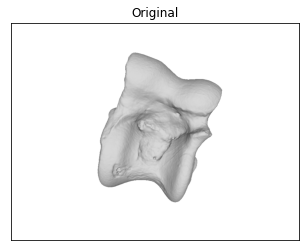

Original size (764, 1013, 3)
RESIZED (220, 220, 3)
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


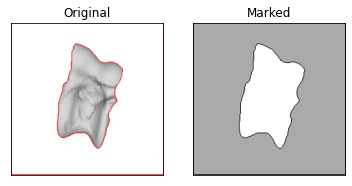

In [30]:
processing("goat")